<a href="https://colab.research.google.com/github/zihvvan/DeepLearning/blob/main/zihvvan/ch09_DL_04_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN 모델 구현하기

* CNN 모델은 컨볼루션, 풀링, 드롭아웃, 그리고 일반적인 신경망 계층의 조합으로 이루어짐

## 환경설정

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# USE_CUDA, DEVICE
USE_CUDA = torch.cuda.is_available() # 계산을 가속해주는 CUDA를 쓸 수 있는지 확인
DEVICE = torch.device("cuda" if USE_CUDA else "cpu") # CUDA 사용 가능 여부에 따라, 데이터를 CUDA(GPU) 혹은 CPU로 보낼지 결정

In [3]:
print(USE_CUDA, DEVICE)

True cuda


In [4]:
# 에포크, 배치 크기 - 하이퍼 패러미터
EPOCHS = 40
BATCH_SIZE = 64

# 학습용과 테스트용 데이터셋 불러오기
* 코드를 간결하게 하기 위해서 Fashion MNIST 데이터셋을 DataLoader를 부를 때 바로 정의
* transfroms를 이용한 전처리 → 파이토치 텐서화, 정규화 진행

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data',
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307), (0.3081,))
                       
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data',
                   train=False, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   transforms.Normalize((0.1307), (0.3081,))  
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



In [6]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)

(3, 224, 224)


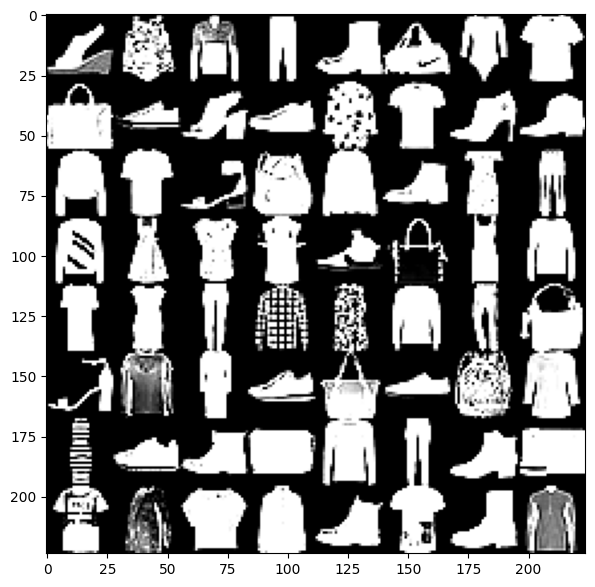

In [7]:
images, labels = next(dataiter)

img = utils.make_grid(images, padding=0)
npimg = img.numpy()
print(npimg.shape)
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

## 신경망 만들기

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CNN 모델 -> 커널 크기 5x5이고, 컨볼루션 계층은 2개
        # nn.Conv2d 모듈 -> 입력 x를 받는 함수
        # self.conv1, self.conv2 -> CNN 모델의 내부 변수(속성)들은 함수로 취급

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # 1개의 색상 차원이 10개의 특징 맵을 생성
        # nn.Conv2d(입력 채널 수, 출력 채널 수)
        # 필터(커널) 크기 = kernel_size로 지정 -> 숫자 하나만 지정하면 정사각형으로 간주
        # (3, 5) -> 이런 모양을 입력하면 해당 모양의 직사각형 필터도 가능.
        # 이미지들은 색상으로 input 값을 받음. (흑백 이미지 = 1개)
        
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        # 10개의 특징 맵(conv1)을 받아서 20개의 특징 맵을 만듦

        # 컨볼루션 결과값 -> 출력값. dropout (특정한 가중치에 편중되지 않게, 과적합 막기 위해)
        self.conv2_drop = nn.Dropout2d()

        # --- -> 특징을 추려내는 과정 / 특징을 통해서 분류를 실행

        # 컨볼루션 & 드롭아웃은 거친 이미지 -> 일반 신경망
        # 첫 신경망 계층 -> 앞 계층의 출력 크기인 320을 입력 크기, 출력 크기 50.
        # 20 x 4 x 4 -> 320 -> 50
        self.fc1 = nn.Linear(20 * 4 * 4, 50) # 320 = 20 x 4 x 4 -> 320 => 50

        # 두번째 계층 -> 앞 계층의 출력 크기인 50을 입력 크기, 출력을 분류할 클래스 개수인 10개로 설정
        # 각 계층의 출력 크기는 줄어들기만 하면 됨 (적당히)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x): # 데이터 흐름 정의
        # 입력 x를 받아서 컨볼루션 계층(1번째)을 거치게 한 후, 최대풀링을 진행
        # self.conv1을 거쳐서 -> F.max_pool2d(특징맵, 커널 크기) -> 학습 파라미터 없음 nn? F?
        # 활성화 함수 F.relu 거치도록
        # print(x.shape) # 1, 28, 28 - 컨볼루션의 커널 사이즈 - 1 만큼은 이미지가 축소 => 특징 10개를 가지는 (28-4) 24x24 이미지
        # x = self.conv1(x) # kernel 5 x 5
        # x = F.max_pool2d(x, 2) # 풀링도 커널 사이즈 (2x2)
        # x = F.relu(x)
        x =  F.relu(F.max_pool2d(self.conv1(x), 2))
        # before pooling: 10, 24, 24 # 24 -> 12
        # pooling : 10, 12, 12
        # print(x.shape)

        # 이 과정을 2번째 컨볼루션 계층에도 반복
        # x =  F.relu(F.max_pool2d(self.conv2(x), 2))
        # conv2_drop을 통해서 drop 추가
        x =  F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # before pooling: : 20, 8, 8
        # pooling : 20, 4, 4
        # print(x.shape)

        # 특징 맵 -> 1차원으로 펴주기 (view)
        x = x.view(-1, 20 * 4 * 4) # -1 남는 차원 모두. 320개는 원소 개수.
        # print(x.shape)

        # 분류 신경망 구성
        # 1번째 신경망
        # x = self.fc1(x) # 320 -> 50
        # x = F.relu(x)
        x = F.relu(self.fc1(x))
        # print(x.shape)
        # 드롭아웃        
        x = F.dropout(x, training=self.training) # 훈련모드일 때만 dropout
        # 마지막 계층 (0-9까지의 레이블을 갖는 10개의 출력값을 가지는 신경망)
        x = self.fc2(x)
        return x

In [13]:
class Net(nn.Module): # nn.Module을 통해서 신경망 모듈을 상속 (Net -> CNN)
    def __init__(self):
        # 생성자 -> 신경망의 구조 관련된 내용을 정의,
        # 주로 가중치가 학습되어야 하거나 신경망 구조에서 반복적으로 사용되는 요소들을 정의
        # 외부에서 전달 받는 설정값 (input_size? dropout_p?)
        super(Net, self).__init__() # 생성자 오버라이드를 했으므로 부모 클래스의 생성자를 실행 (nn.Module의 속성들을 이어 받기 위함)
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # nn.Conv2d -> 2차원(행렬)의 합성곱층. 입력 채널 수, 출력 채널 수, kernel_size -> 묶음 사이즈
        # 커널 사이즈 -> 얼마나 많은 범위의 특징이 담기냐 -> 크기에 따라서 이미지가 축소됨. -> 커널 사이즈 수 - 1 만큼 (정사각형) 줄어듬
        # 1, 28, 28 -> 10, 24, 24 -> 10, 12, 12
        # -> 컨볼루션 계층 -> 풀링 계층
        # 풀링 -> 최대 풀링 -> 특정 커널의 범위에 있는 값중에 최대값 1개만 추출하겠다
        # 10, 12, 12 -> 20, 8, 8 -> (드롭아웃) -> 20, 4, 4
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        # fc -> 선형결합을 해서 한줄로 펴준다음에 우리가 분류하기를 원하는 클래스 값만큼 특징을 다시 분류
        # fc1 -> 20, 4, 4 -> 320 -> 50 (활성화함수) (드롭아웃)
        self.fc1 = nn.Linear(20 * 4 * 4, 50)
        # fc2 -> 50 -> 10
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x): # init에서 설계했던 대로 forward를 채우면 됨
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # F.max_pool2d => 뒤에 표시한 커널의 크기만큼 특징맵을 묶어서 처리 (최대값값)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 20 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

* Pytorch로 CNN 모델을 만드는데 도움을 줘
* 모델의 인풋 데이터는 가로세로 28px의 흑백데이터고, CNN을 통해서 합성곱 층을 2개 같길 원해. 해당 합성곱층은 커널사이즈가 5고 스트라이드는 1만 쓰고, 패딩은 안 쓸거야. 그리고 2개의 MLP층을 가져서 최종적으로는 10개의 이미지로 분류하길 원해. 2번째 합성곱층과 1번째 MLP층에는 드롭아웃을 적용해줘. 1번째 MLP에서의 드롭아웃은 훈련셋에서만 적용되어야 해.

In [9]:
# CNN 모델의 인스턴스와 최적화 함수 생성
model = Net().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

최적화 알고리즘 중 하나인 Momentum 최적화 방법에서, momentum은 gradient를 업데이트할 때, 이전 gradient 값의 일정 비율만큼을 추가로 사용하는 기법입니다.

즉, 현재 gradient 값을 업데이트할 때, 이전 gradient 값의 일정 비율만큼을 현재 gradient 값에 더해주는 것입니다. 이전 gradient 값을 활용하여 업데이트를 수행함으로써, gradient의 방향성을 유지하면서 빠르게 수렴할 수 있게 됩니다.

Momentum 최적화 방법은 SGD보다 더 빠르게 수렴하며, 특히 경사면이 불규칙한 곳에서 효과적입니다. Momentum 값이 작을수록 이전 gradient 값을 적게 반영하게 되어, SGD와 유사한 업데이트를 수행하게 됩니다. 반면, Momentum 값이 클수록 이전 gradient 값을 많이 반영하게 되어, 수렴이 더 빨라집니다.

Momentum 최적화 방법에서는 일반적으로 0.9와 같이 0.0 ~ 1.0 사이의 값을 사용합니다.

In [10]:
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [11]:
from torchsummary import summary as summary_ # 모델의 구조를 확인

summary_(model, (1,28,28), batch_size=64)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 10, 24, 24]             260
            Conv2d-2             [64, 20, 8, 8]           5,020
         Dropout2d-3             [64, 20, 8, 8]               0
            Linear-4                   [64, 50]          16,050
            Linear-5                   [64, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 4.09
Params size (MB): 0.08
Estimated Total Size (MB): 4.37
----------------------------------------------------------------


In [14]:
# 훈련 함수
def train(model, train_loader, optimizer, epoch): # 모델, 훈련 데이터셋, 최적화 함수, 에포크 차수
    # 모델을 train 모드 -> dropout 활성화
    # 데이터셋에서 배치를 가져와 모델에서 출력값을 뽑음
    for batch_idx, (data, target) in enumerate(train_loader): # 데이터 로더의 인덱스(배치별), 그 값
    # 그 값 -> data, 라벨
        data, target = data.to(DEVICE), target.to(DEVICE) # 텐서들 -> 모델과 연결된 장치로 보내주기
        optimizer.zero_grad() # 배치 돌 때마다 기울기값(최적화) 리셋
        output = model(data) # 모델을 거친 데이터 -> output
        loss = F.cross_entropy(output, target) # 크로스 엔트로피 오차 함수로 오차값 계산
        # 예측값과 정답값 사이의 교차 엔트로피 -> 손실(에러) 계산
        loss.backward() # 오차역전파 -> 미분계수 전달
        optimizer.step() # 모델의 학습 패러미터 갱신 / 가중치 (conv도 갱신, linear 갱신)

        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [15]:
# 성능 확인 코드
def evaluate(model, test_loader):
    model.eval() # 평가 모드
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE) # 텐서들 -> 모델과 연결된 장치로 보내주기
            output = model(data) # 모델을 거친 데이터 -> output
            
            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

output.max(1, keepdim=True)은 출력 텐서 output의 각 행(row)에서 최대값과 해당 인덱스를 반환합니다. 반환값은 크기가 (N, 1)인 텐서입니다. N은 output의 행(row)의 개수입니다.

[1]은 반환된 (N, 1) 크기의 텐서에서 인덱스에 해당하는 부분만 선택하는 인덱싱 연산입니다. 따라서 pred는 크기가 (N,)인 1차원 텐서입니다.

keepdim=True를 사용하지 않으면 max() 연산이 적용된 차원이 사라지므로 (N, 1)이 아닌 (N,) 크기의 텐서가 반환됩니다. keepdim=True를 사용하여 차원을 유지하면서 최대값과 해당 인덱스를 반환하므로, 나중에 인덱싱 연산을 수행할 때 편리합니다.

In [16]:
# DNN으로 구현했던 FashionMNIST를 CNN으로 개선
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306809
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.252491
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.962224
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.852785
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.883369
[1] Test Loss: 0.6874, Accuracy: 73.00%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.619160
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.542833
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.563474
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.529603
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.507780
[2] Test Loss: 0.4899, Accuracy: 81.73%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.437273
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.391653
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.481713
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.618866
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.633997
[3] Test Loss: 0.4424, Accuracy: 83.58%
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.332078
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.310758
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.439850
